In [1]:
%cd ..

/Users/mateoibarguen/Desktop/DATA 401/data_401_vodka


## Final Iowa Liquor Sale Notebook

In [2]:
import itertools
import pandas as pd
from src.statistical_lr import StatLinearRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Data Exploration

In [41]:
vodka_df = pd.read_csv('data/merged_vodka.csv')
vodka_df.rename({'avg_bottle_volume_sold_per_capita': 'volume_sold_per_capita'}, inplace=True, axis=1)
vodka_df.head()

,county,year,quarter,category,avg_bottle_volume,avg_percent_markup,num_unique_stores_per_capita,num_unique_vendors_per_capita,volume_sold_per_capita,graduation_rate,unemp_rate,prct_dem,prct_rep,prct_NP
0,ADAIR,2012,1,amaretto,0.916667,0.500742,0.000803,0.000536,0.001540,95.6,5.3,0.221747,0.385196,0.392881
1,ADAIR,2012,1,brandy,0.660088,0.368355,0.003053,0.003053,0.004614,95.6,5.3,0.221747,0.385196,0.392881
2,ADAIR,2012,1,cocktail,1.638889,0.512525,0.002066,0.001549,0.004969,95.6,5.3,0.221747,0.385196,0.392881
3,ADAIR,2012,1,creme,0.750000,0.500000,0.000134,0.000134,0.000234,95.6,5.3,0.221747,0.385196,0.392881
4,ADAIR,2012,1,gin,0.976562,0.499606,0.001224,0.000918,0.001329,95.6,5.3,0.221747,0.385196,0.392881


### Explore Correlations

In [4]:
def color_corr(val):
    return 'background-color: yellow' if np.abs(val) > 0.6 else  ''

In [17]:
corr_df = vodka_df.loc[:, ~vodka_df.columns.isin(['volume_sold_per_capita'])].corr()
corr_df.style.applymap(color_corr)

,year,quarter,avg_bottle_volume,avg_percent_markup,num_unique_stores_per_capita,num_unique_vendors_per_capita,graduation_rate,unemp_rate,prct_dem,prct_rep,prct_NP
year,1,-0.0847164,0.026865,-0.0433207,0.152313,0.192996,0.131137,-0.609909,-0.118867,0.0929746,-0.031291
quarter,-0.0847164,1,-0.0140613,0.0981048,-0.0261048,-0.0212205,0.000745427,-0.346764,-0.00752439,0.0107035,-0.0105236
avg_bottle_volume,0.026865,-0.0140613,1,0.126503,-0.000658559,0.041097,0.0344753,-0.0277435,-0.0582276,0.0405075,0.00810109
avg_percent_markup,-0.0433207,0.0981048,0.126503,1,-0.00804036,-0.008812,-0.00655664,-0.027046,0.0035628,-0.00567451,0.00730203
num_unique_stores_per_capita,0.152313,-0.0261048,-0.000658559,-0.00804036,1,0.602297,-0.00173603,-0.0685217,0.133069,-0.0844831,-0.0415276
num_unique_vendors_per_capita,0.192996,-0.0212205,0.041097,-0.008812,0.602297,1,0.00853335,-0.100796,0.00902213,-0.0081437,-0.00347252
graduation_rate,0.131137,0.000745427,0.0344753,-0.00655664,-0.00173603,0.00853335,1,-0.215696,-0.11634,0.0930529,-0.00801649
unemp_rate,-0.609909,-0.346764,-0.0277435,-0.027046,-0.0685217,-0.100796,-0.215696,1,0.330719,-0.296708,0.105204
prct_dem,-0.118867,-0.00752439,-0.0582276,0.0035628,0.133069,0.00902213,-0.11634,0.330719,1,-0.856908,0.17845
prct_rep,0.0929746,0.0107035,0.0405075,-0.00567451,-0.0844831,-0.0081437,0.0930529,-0.296708,-0.856908,1,-0.659736


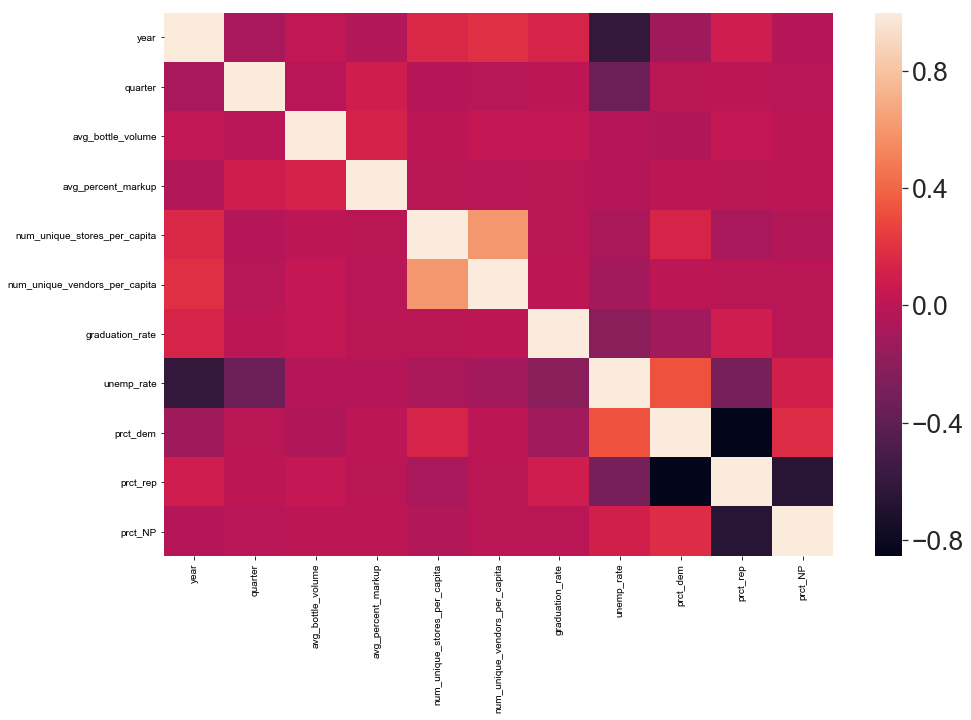

In [45]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.set(font_scale=2.4)
sns.heatmap(corr_df)

### Interesting Relationships

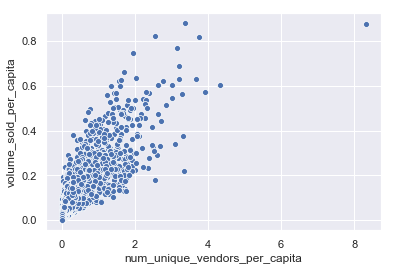

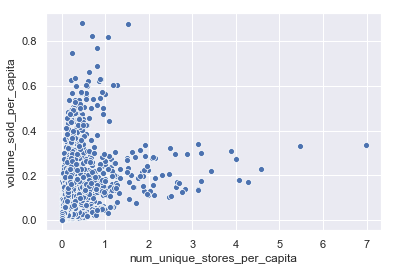

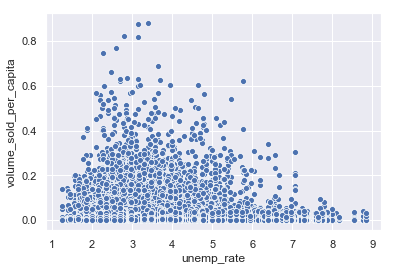

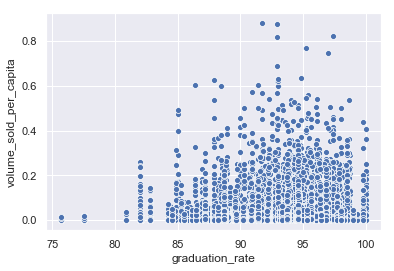

In [19]:
sns.set(font_scale=1)
interesting_vars = ['num_unique_vendors_per_capita', 'num_unique_stores_per_capita', 'unemp_rate', 'graduation_rate']
for var in interesting_vars:
    sns.scatterplot(x = var, y = 'volume_sold_per_capita', data=vodka_df)
    plt.show()

### Obtain interaction terms

In [6]:
def create_interaction_terms(df, interactions_list):
    for interaction in interactions_list:
        first_col, second_col = interaction[0], interaction[1]
        new_column_name = first_col + "_X_" + second_col
        df[new_column_name] = df[first_col] * df[second_col]
    return df

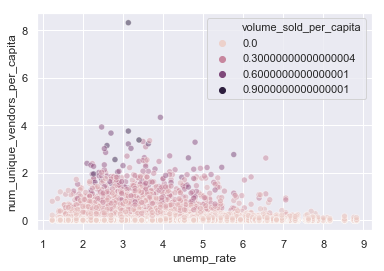

In [22]:
sns.scatterplot(x = 'unemp_rate', y = 'num_unique_vendors_per_capita', data=vodka_df, hue='volume_sold_per_capita', alpha=0.5)

### Obtain subsets

In [49]:
def get_subsets(x_columns):
    subs = []
    for r in range(len(x_columns)):
        combinations = [c for c in itertools.combinations(x_columns, r)]
        subs.extend(combinations)
    return subs[1:]

In [46]:
def fit_subsets(df, x_columns, y_var):
    y = df.iloc[:, -1]
    subsets = get_subsets(x_columns)
    print(f'Length of subsets {len(subsets)}')
    lr_subsets = []
    lr_r_squared_scores = []
    lr_ad_r_squared_scores = []
    lr_bic_scores = []
    i = 0
    for s in subsets:
        i += 1
        if i % 100 == 0:
            print(i)
        lr = StatLinearRegression()
        lr.fit_transform_df(df, list(s), y_var=y_var)
        lr_subsets.append(lr)
        lr_r_squared_scores.append(lr.r_squared)
        lr_ad_r_squared_scores.append(lr.adjusted_r_squared)
        lr_bic_scores.append(lr.bic)
    return {'model': lr_subsets, 'r_squared': lr_r_squared_scores, 'adjusted_r_squared': lr_ad_r_squared_scores, 'bic': lr_bic_scores}

## Statistical Model

### Prepare data for model.

In [89]:
# Drop pct_rep
# Add interesting interaction. 
vodka_df = pd.read_csv('data/merged_vodka.csv')
vodka_df.rename({'avg_bottle_volume_sold_per_capita': 'volume_sold_per_capita'}, inplace=True, axis=1)

vodka_df = create_interaction_terms(vodka_df, [('num_unique_vendors_per_capita', 'unemp_rate')])
vodka_df.drop('prct_rep', axis=1, inplace=True)
vodka_df.drop('prct_NP', axis=1, inplace=True)
vodka_df = vodka_df.replace([np.inf, -np.inf], np.nan)
vodka_df.dropna(inplace=True)
X_cols = [c for c in vodka_df.columns if c not in  {'volume_sold_per_capita', 'log_volume_sold_per_capita'}]

#### Backwards Stepwise BIC

In [90]:
bic_scores = []
models = []
def backwards_stepwise(df, parent_model):
    if len(parent_model.input_col_names) <= 1:
        return
    diff_bic_list = []
    diff_bic_model = {}
    
    for i in range(len(parent_model.input_col_names)):
        smaller_cols = parent_model.input_col_names.copy()[:i] + parent_model.input_col_names.copy()[i+1:]
        lr = StatLinearRegression()
        lr.fit_transform_df(df, x_cols=smaller_cols)
        diff_bic = parent_model.bic - lr.bic
        diff_bic_list.append(diff_bic)
        diff_bic_model[diff_bic] = lr
        
    max_diff = np.array(diff_bic_list).max()
    best_model = diff_bic_model[max_diff]
    if max_diff > 0:
        models.append(best_model)
        bic_scores.append(best_model.bic)
        return backwards_stepwise(df, best_model)
    return {'bic': bic_scores, 'models': models}
        

In [91]:
bic_scores = []
models = []
parent_model = StatLinearRegression()
parent_model.fit_transform_df(vodka_df, X_cols)
bic_dict = backwards_stepwise(vodka_df, parent_model)

In [92]:
bic_scores_df = pd.DataFrame.from_dict(bic_dict)
sorted_bic = bic_scores_df.sort_values(by='bic')

In [93]:
sorted_bic.iloc[0, 1].input_col_names

['year',
 'category',
 'num_unique_stores_per_capita',
 'num_unique_vendors_per_capita',
 'num_unique_vendors_per_capita_X_unemp_rate']

### Residual Diagnostic Plots

In [83]:
best_model = bic_scores_df.sort_values(by='bic').iloc[0, 1]

In [84]:
best_model_coeffs = best_model.input_col_names

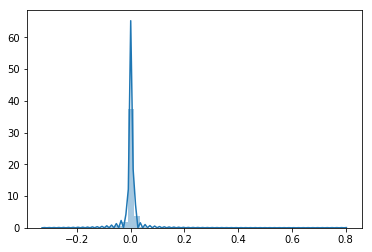

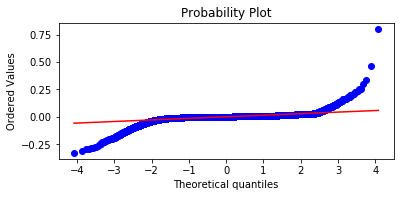

NormaltestResult(statistic=14261.196912476667, pvalue=0.0)


In [22]:
bic_scores_df.sort_values(by='bic').iloc[0, 1].plot_residuals()

### Transform Response

In [96]:
vodka_df['log_volume_sold_per_capita'] = np.log(vodka_df['volume_sold_per_capita'])

In [97]:
lr_log = StatLinearRegression()
lr_log.fit_transform_df(vodka_df, x_cols=sorted_bic.iloc[0, 1].input_col_names, y_var='log_volume_sold_per_capita')

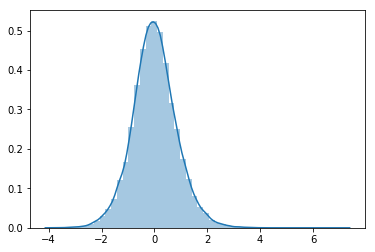

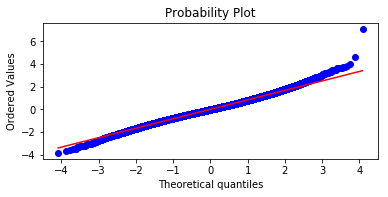

NormaltestResult(statistic=645.9646974208154, pvalue=5.37710110965641e-141)


In [87]:
lr_log.plot_residuals()

In [98]:
lr_log.coeffs_names

{'year': 0.28539914959565915,
 'num_unique_stores_per_capita': 0.502435100480993,
 'num_unique_vendors_per_capita': 0.6646760748221237,
 'num_unique_vendors_per_capita_X_unemp_rate': 0.1389723214026195,
 'int': -581.6663049379129,
 'category_anisette': -2.7779392381943726,
 'category_brandy': 1.2288037242644236,
 'category_cocktail': 1.5455660746158033,
 'category_creme': -1.30877428773751,
 'category_gin': 1.0983925688918303,
 'category_mezcal': -3.0587614637855873,
 'category_other': -0.457668799882131,
 'category_package': -0.18895258756457434,
 'category_rum': 2.8171895618142564,
 'category_schnapps': 1.8309292170105373,
 'category_spirit': -0.14460308970752153,
 'category_tequila': 1.1613125177231174,
 'category_triple sec': -0.05714661101619294,
 'category_vodka': 3.25625555939983,
 'category_whiskey': 3.332723383699609}

In [101]:
lr_log.bic

6378.709299237892

#### Interpretive Model Results

In [27]:
print(f'R-squared: {lr_log.r_squared}')
print(f'Adjusted-R-squared: {lr_log.adjusted_r_squared}')
print(f'BIC: {lr_log.bic}')

R-squared: 0.805757570262801
Adjusted-R-squared: 0.8056217622969262
BIC: 6344.36252825917


## Predictive Model

In [29]:
vodka_df.drop('log_volume_sold_per_capita', axis=1, inplace=True)

In [71]:
def fit_df_cv(df, num_folds, x_cols):
    prediction_error_every_fold = []

    n = df.shape[0]

    observations_per_fold = np.ceil(n / num_folds)
    index_list = np.array(range(num_folds)).repeat(observations_per_fold)[:n]
    np.random.shuffle(index_list)    
    lr = StatLinearRegression()
    lr.fit_df(df, x_cols)

    for fold in range(num_folds):
        current_test_fold = np.where(index_list == [fold])[0]
        X_train, y_train = lr.X[~current_test_fold], lr.y[~current_test_fold]
        X_test, y_test = lr.X[current_test_fold], lr.y[current_test_fold]
        lr.transform(X_train, y_train)
        fold_error = lr.compute_error(X_test, y_test)
        prediction_error_every_fold.append(fold_error)

    return lr, np.sum(prediction_error_every_fold) / num_folds

In [72]:
avg_sse_scores = []
models = []
def backwards_stepwise_cv(df, parent_model, parent_avg_sse):
    if len(parent_model.input_col_names) <= 1:
        return
    diff_sse_list = []
    diff_sse_model = {}
    sse_model = {}
    
    for i in range(len(parent_model.input_col_names)):
        smaller_cols = parent_model.input_col_names.copy()[:i] + parent_model.input_col_names.copy()[i+1:]
        model, avg_sse = fit_df_cv(vodka_df, 5, smaller_cols)
        diff_sse = parent_avg_sse - avg_sse
        diff_sse_list.append(diff_sse)
        diff_sse_model[diff_sse] = model
        sse_model[model] = avg_sse
        
        
    max_diff = np.array(diff_sse_list).max()
    best_model = diff_sse_model[max_diff]
    best_sse = sse_model[best_model]
    
    if max_diff > 0:
        models.append(best_model)
        avg_sse_scores.append(best_sse)
        return backwards_stepwise_cv(df, best_model, best_sse)
    
    return {'models': models, 'avg_sse': avg_sse_scores}
        

In [73]:
def fit_cv(df, num_folds, x_cols):
    subsets = get_subsets(x_cols)
    print(f'Length of subsets {len(subsets)}')
    i = 0
    models = []
    avg_sse_list = []
    
    for subset in subsets:
        i += 1
        if i % 100 == 0:
            print(i)
        model, avg_sse = fit_df_cv(df, num_folds, list(subset))
        models.append(model)
        avg_sse_list.append(avg_sse)
        
    return {'models': models, f'avg_sse_{num_folds}_folds': avg_sse_list}

In [102]:
# Drop pct_rep
# Add interesting interaction. 
vodka_df = pd.read_csv('data/merged_vodka.csv')
vodka_df.rename({'avg_bottle_volume_sold_per_capita': 'volume_sold_per_capita'}, inplace=True, axis=1)

vodka_df = create_interaction_terms(vodka_df, [('num_unique_vendors_per_capita', 'unemp_rate')])
vodka_df.drop('prct_rep', axis=1, inplace=True)
vodka_df.drop('prct_NP', axis=1, inplace=True)
vodka_df = vodka_df.replace([np.inf, -np.inf], np.nan)
vodka_df.dropna(inplace=True)

X_cols = [c for c in vodka_df.columns if c not in  {'volume_sold_per_capita', 'log_volume_sold_per_capita'}]

lr = StatLinearRegression()
lr.fit_transform_df(vodka_df, X_cols)
avg_sse_scores = []
models = []
cv_dict = backwards_stepwise_cv(vodka_df, lr, lr.sse)

In [106]:
cv_df = pd.DataFrame.from_dict(cv_dict)
sorted_sse = cv_df.sort_values(by='avg_sse')

In [127]:
print('Best model results: ')
print(f'Avg. SSE: {sorted_sse.iloc[0, 1]}')
print(f'R-squared: {sorted_sse.iloc[0, 0].r_squared}')
print(f'Adjusted R-squared: {sorted_sse.iloc[0, 0].adjusted_r_squared}')

Best model results: 
Avg. SSE: 2.3709642814950938
R-squared: 0.9692960171120011
Adjusted R-squared: 0.9691765920685675
